In [1]:
import numpy as np

In [45]:
#site referencia: https://github.com/Yeok-c/Stewart_Py/blob/main/01_Stewart_Py_Inverse_Kinematics.ipynb
#init_printing()

In [14]:
r_B, r_P, gamma_B, gamma_P = 6.2, 5, 0.2269, 0.82
# 0.2269rad is 13 degrees, which is standard gamma_B for stewart platforms

pi = np.pi

## Define the Geometry of the platform
# Psi_B (Polar coordinates)
psi_B = np.array([ 
    -gamma_B, 
    gamma_B,
    2*pi/3 - gamma_B, 
    2*pi/3 + gamma_B, 
    2*pi/3 + 2*pi/3 - gamma_B, 
    2*pi/3 + 2*pi/3 + gamma_B])

# psi_P (Polar coordinates)
# Direction of the points where the rod is attached to the platform.
psi_P = np.array([ 
    pi/3 + 2*pi/3 + 2*pi/3 + gamma_P,
    pi/3 + -gamma_P, 
    pi/3 + gamma_P,
    pi/3 + 2*pi/3 - gamma_P, 
    pi/3 + 2*pi/3 + gamma_P, 
    pi/3 + 2*pi/3 + 2*pi/3 - gamma_P])

# Coordinate of the points where servo arms 
# are attached to the corresponding servo axis.


B = np.array( [ 
    [ 1.7580, 2.8, -1.015],
    [ 1.6021, 3.07, -0.925],
    [ -1.7580, 2.8, -1.015],
    [ -1.6021, 3.07, -0.925],
    [ 0, 2.8, 2.03],
    [ 0, 3.07, 1.85] ])

#B = r_B * np.array( [ 
#    [ np.cos(psi_B[0]), np.sin(psi_B[0]), 0],
#    [ np.cos(psi_B[1]), np.sin(psi_B[1]), 0],
#    [ np.cos(psi_B[2]), np.sin(psi_B[2]), 0],
#    [ np.cos(psi_B[3]), np.sin(psi_B[3]), 0],
#    [ np.cos(psi_B[4]), np.sin(psi_B[4]), 0],
#    [ np.cos(psi_B[5]), np.sin(psi_B[5]), 0] ])

B = np.transpose(B)
    
# Coordinates of the points where the rods 
# are attached to the platform.
P = r_P * np.array([ 
    [ np.cos(psi_P[0]),  np.sin(psi_P[0]), 0],
    [ np.cos(psi_P[1]),  np.sin(psi_P[1]), 0],
    [ np.cos(psi_P[2]),  np.sin(psi_P[2]), 0],
    [ np.cos(psi_P[3]),  np.sin(psi_P[3]), 0],
    [ np.cos(psi_P[4]),  np.sin(psi_P[4]), 0],
    [ np.cos(psi_P[5]),  np.sin(psi_P[5]), 0] ])
P = np.transpose(P)


print('6x1 array for psi_B \n', psi_B)
print('6x3 array for Base anchors \n', B)
#print('6x3 array for Platform anchors \n', P)
#print('6x1 array for psi_P \n', psi_P)

6x1 array for psi_B 
 [-0.2269     0.2269     1.8674951  2.3212951  3.9618902  4.4156902]
6x3 array for Base anchors 
 [[ 1.758   1.6021 -1.758  -1.6021  0.      0.    ]
 [ 2.8     3.07    2.8     3.07    2.8     3.07  ]
 [-1.015  -0.925  -1.015  -0.925   2.03    1.85  ]]


In [15]:
B[0,:]

array([ 1.758 ,  1.6021, -1.758 , -1.6021,  0.    ,  0.    ])

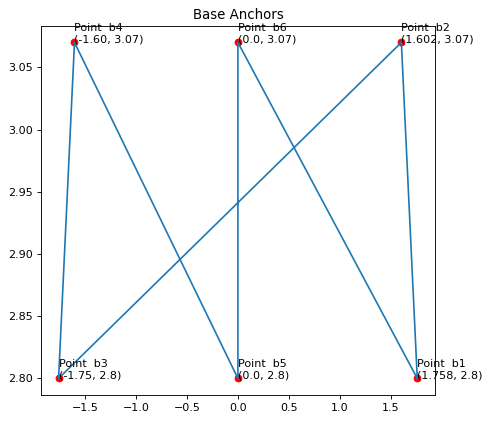

In [18]:
import matplotlib.pyplot as plt
#import seaborn

def plot_2D_annotate(X, Y):
    X = list(X)
    Y = list(Y)
    ax.plot(X,Y, 'or')  # Plot Points
    # Annotate Points
    for i, (xy) in enumerate(zip(X, Y)):                                 
        ax.annotate('Point ' + ' b'+ str(i+1) + '\n(%.5s, %.5s)' % xy, xy=xy, textcoords='data')

    X.append(X[0])
    Y.append(Y[0])
    ax.plot(X,Y)    # Plot lines

#seaborn.set(style='ticks')
# plt.style.use('dark_background')

fig = plt.figure(figsize=(14, 6), dpi=80)

ax = fig.add_subplot(121)
ax.set_title('Base Anchors')
plot_2D_annotate(B[0,:], B[1,:])
#circle_B = plt.Circle((0, 0), r_B, color='g', fill=False)
#ax.add_patch(circle_B)

#ax = fig.add_subplot(122)
#ax.set_title('Platform Anchors')
#plot_2D_annotate(P[0,:], P[1,:])
#circle_r = plt.Circle((0, 0), r_P, color='g', fill=False)
#ax.add_patch(circle_r)

plt.show()

In [48]:
# # Definition of the platform home position.
home_pos= np.array([0, 0, 2*r_B])

# Allocate for variables
l = np.zeros((3,6))
lll = np.zeros((6))

# Rotation matrices used later
def rotX(theta):
    rotx = np.array([
        [1,     0    ,    0    ],
        [0,  np.cos(theta), -np.sin(theta)],
        [0,  np.sin(theta), np.cos(theta)] ])
    return rotx

def rotY(theta):    
    roty = np.array([
        [np.cos(theta), 0,  np.sin(theta) ],
        [0         , 1,     0       ],
        [-np.sin(theta), 0,  np.cos(theta) ] ])   
    return roty
    
def rotZ(theta):    
    rotz = np.array([
        [ np.cos(theta),-np.sin(theta), 0 ],
        [ np.sin(theta), np.cos(theta), 0 ],
        [   0        ,     0      , 1 ] ])   
    return rotz

In [49]:
l.shape

(3, 6)

In [50]:
# Given input trans, rotation
trans = np.transpose(np.array([0,0,0])) # X, Y, Z
rotation = np.transpose(np.array([0,0,pi/6])) # X, Y, Z

# Get rotation matrix of platform. RotZ* RotY * RotX -> matmul
# R = np.matmul( np.matmul(rotZ(rotation[2]), rotY(rotation[1])), rotX(rotation[0]) )
R = np.matmul( np.matmul(rotX(rotation[0]), rotY(rotation[1])), rotZ(rotation[2]) )

# Get leg length for each leg
# leg = np.repeat(trans[:, np.newaxis], 6, axis=1) + np.repeat(home_pos[:, np.newaxis], 6, axis=1) + np.matmul(np.transpose(R), P) - B 
l = np.repeat(trans[:, np.newaxis], 6, axis=1) + np.repeat(home_pos[:, np.newaxis], 6, axis=1) + np.matmul(R, P) - B 
lll = np.linalg.norm(l, axis=0)

# Position of leg in global frame
L = l + B

print('Leg lengths to command in order to achieve desired position of plate: \n', lll)

Leg lengths to command in order to achieve desired position of plate: 
 [12.6048705  13.03117822 12.6048705  13.03117822 12.6048705  13.03117822]


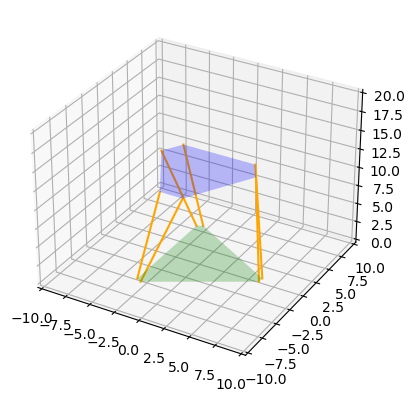

In [51]:
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

def plot3D_line(ax, vec_arr_origin, vec_arr_dest, color_):
    for i in range(6):
        ax.plot([vec_arr_origin[0, i] , vec_arr_dest[0, i]],
        [vec_arr_origin[1, i], vec_arr_dest[1, i]],
        [vec_arr_origin[2, i],vec_arr_dest[2, i]],
        color=color_)

#interactive plotting in separate window
# Comment out this and restart kernel if you're having issues with interactive plot (qt)
# %matplotlib qt

ax = plt.axes(projection='3d') # Data for a three-dimensional line
ax.set_xlim3d(-10, 10)
ax.set_ylim3d(-10, 10)
ax.set_zlim3d(0, 20)

# ax.add_collection3d(Poly3DCollection([list(np.transpose(s.B))]), zs='z')
ax.add_collection3d(Poly3DCollection([list(np.transpose(B))], facecolors='green', alpha=0.25))

# ax.add_collection3d(base_plot, zs='z')
ax.add_collection3d(Poly3DCollection([list(np.transpose(L))], facecolors='blue', alpha=0.25))

plot3D_line(ax, B, L, 'orange')
plt.show()